# imfp

[![Tests](https://github.com/chriscarrollsmith/imfp/actions/workflows/main.yml/badge.svg)](https://github.com/chriscarrollsmith/imfp/actions/workflows/main.yml)
[![PyPI Version](https://img.shields.io/pypi/v/imfp.svg)](https://pypi.python.org/pypi/imfp)
[![Code style: black](https://img.shields.io/badge/code%20style-black-000000.svg)](https://github.com/psf/black)

`imfp`, by Christopher C. Smith, is a Python package for downloading data from the [International Monetary
Fund's](http://data.imf.org/) [RESTful JSON
API](http://datahelp.imf.org/knowledgebase/articles/667681-using-json-restful-web-service).

## Installation

To install the stable version of imfp from PyPi, use pip.

In [ ]:
pip install -q --upgrade imfp

To load the library, use `import`:

In [4]:
import imfp


## Usage

### Suggested packages

`imfp` outputs data in a `pandas` data frame, so you will want to use the `pandas` package for its functions for viewing and manipulating this object type. I also recommend `matplotlib` or `seaborn` for making plots, and `numpy` for computation. These packages can be installed using `pip` and loaded using `import`:

In [5]:
import seaborn


### Fetching an Index of Databases with the `imf_databases` Function

The `imfp` package introduces four core functions: `imfp.imf_databases`, `imfp.imf_parameters`, `imfp.imf_parameter_defs`, and `imfp.imf_dataset`. The function for downloading datasets is `imfp.imf_dataset`, but you will need the other functions to determine what arguments to supply to `imfp.imf_dataset`. For instance, all calls to `imfp.imf_dataset` require a `database_id`. This is because the IMF serves many different databases through its API, and the API needs to know which of these many databases you're requesting data from. To obtain a list of databases, use `imfp.imf_databases`, like so:

In [7]:
#Fetch the list of databases available through the IMF API
databases = imfp.imf_databases()
databases.head()

,database_id,description
0,BOP_2017M06,"Balance of Payments (BOP), 2017 M06"
1,BOP_2020M3,"Balance of Payments (BOP), 2020 M03"
2,BOP_2017M11,"Balance of Payments (BOP), 2017 M11"
3,DOT_2020Q1,"Direction of Trade Statistics (DOTS), 2020 Q1"
4,GFSMAB2016,Government Finance Statistics Yearbook (GFSY 2...


This function returns the IMF’s listing of 259 databases available through the API. (In reality, 8 of the listed databases are defunct and not actually available: FAS_2015, GFS01, FM202010, APDREO202010, AFRREO202010, WHDREO202010, BOPAGG_2020, DOT_2020Q1.)

To view and explore the database list, it’s possible to explore subsets of the data frame by row number with `databases.loc`:

In [8]:
# View a subset consisting of rows 5 through 9
databases.loc[5:9]

,database_id,description
5,BOP_2019M12,"Balance of Payments (BOP), 2019 M12"
6,GFSYFALCS2014,Government Finance Statistics Yearbook (GFSY 2...
7,GFSE2016,Government Finance Statistics Yearbook (GFSY 2...
8,FM201510,Fiscal Monitor (FM) October 2015
9,GFSIBS2016,Government Finance Statistics Yearbook (GFSY 2...



 Or, if you already know which database you want, you can fetch the corresponding code by searching for a string match using `str.contains` and subsetting the data frame for matching rows. For instance, here’s how to search for the Primary Commodity Price System:

In [9]:
databases[databases['description'].str.contains("Commodity")]

,database_id,description
237,PCTOT,Commodity Terms of Trade
239,PCPS,Primary Commodity Price System (PCPS)


### Fetching a List of Parameters and Input Codes with `imf_parameters` and `imf_parameter_defs`

Once you have a `database_id`, it’s possible to make a call to `imfp.imf_dataset` to fetch the entire database: `imfp.imf_dataset(database_id)`. However, while this will succeed for a few small databases, it will fail for all of the larger ones. And even in the rare case when it succeeds, fetching an entire database can take a long time. You’re much better off supplying additional filter parameters to reduce the size of your request.

Requests to databases available through the IMF API are complicated by the fact that each database uses a different set of parameters when making a request. (At last count, there were 43 unique parameters used in making API requests from the various databases!) You also have to have the list of valid input codes for each parameter. The `imfp.imf_parameters` function solves this problem. Use the function to obtain the full list of parameters and valid input codes for a given database:

In [10]:
# Fetch list of valid parameters and input codes for commodity price database
params = imfp.imf_parameters("PCPS")

The `imfp.imf_parameters` function returns a dictionary of data frames. Each dictionary key name corresponds to a parameter used in making requests from the database:

In [11]:
# Get key names from the params object
params.keys()

dict_keys(['freq', 'ref_area', 'commodity', 'unit_measure'])

In the event that a parameter name is not self-explanatory, the `imfp.imf_parameter_defs` function can be used to fetch short text descriptions of each parameter:

In [12]:
# Fetch and display parameter text descriptions for the commodity price database
imfp.imf_parameter_defs("PCPS")

,parameter,description
0,freq,Frequency
1,ref_area,Geographical Areas
2,commodity,Indicator
3,unit_measure,Unit


Each named list item is a data frame containing a vector of valid input codes that can be used with the named parameter, and a vector of text descriptions of what each code represents.

To access the data frame containing valid values for each parameter, subset the `params` dict by the parameter name:

In [13]:
# View the data frame of valid input codes for the frequency parameter
params['freq']

,input_code,description
0,A,Annual
1,M,Monthly
2,Q,Quarterly


### Viewing Data Frames

Note that `pandas` data frames in Python can be a little difficult to work with, because Python doesn't have a built-in variable explorer. If you're doing data science, I recommend using an IDE like RStudio or Spyder that has a built-in variable explorer. However, if you don't have a variable explorer, you can prevent Python from truncating data frames using the `options` in `pandas`. For instance, to increase the maximum allowed column width to 100 characters, we can use `pandas.options.display.max_colwidth = 100`.

Alternatively, it's possible to open the data frame in a new window to view it in full:

In [14]:
import imfp
import tempfile
import webbrowser

# Define a simple function to view data frame in a browser window
def View(df):
    html = df.to_html()
    with tempfile.NamedTemporaryFile('w', delete=False, suffix='.html') as f:
        url = 'file://' + f.name
        f.write(html)
    webbrowser.open(url)

# Open data frame in a new browser window using the function
df = imfp.imf_databases()
View(df)

### Supplying Parameter Arguments to `imf_dataset`: A Tale of Two Workflows

There are two ways to supply parameters to `imfp.imf_dataset`: by supplying list arguments or by supplying a modified parameters dict. The list arguments workflow will be more intuitive for most users, but the dict argument workflow requires a little less code.

#### The List Arguments Workflow

To supply list arguments, just find the codes you want and supply them to `imfp.imf_dataset` using the parameter name as the argument name. The example below shows how to request 2000–2015 annual coal prices from the Primary Commodity Price System database:

In [15]:
# Fetch the 'freq' input code for annual frequency
selected_freq = list(
    params['freq']['input_code'][params['freq']['description'].str.contains("Annual")]
)

# Fetch the 'commodity' input code for coal
selected_commodity = list(
    params['commodity']['input_code'][params['commodity']['description'].str.contains("Coal")]
)

# Fetch the 'unit_measure' input code for index
selected_unit_measure = list(
    params['unit_measure']['input_code'][params['unit_measure']['description'].str.contains("Index")]
)

# Request data from the API
df = imfp.imf_dataset(database_id = "PCPS",
         freq = selected_freq, commodity = selected_commodity,
         unit_measure = selected_unit_measure,
         start_year = 2000, end_year = 2015)

# Display the first few entries in the retrieved data frame
df.head()

,freq,ref_area,commodity,unit_measure,unit_mult,time_format,time_period,obs_value
0,A,W00,PCOAL,IX,0,P1Y,2000,39.3510230293202
1,A,W00,PCOAL,IX,0,P1Y,2001,49.3378587284039
2,A,W00,PCOAL,IX,0,P1Y,2002,39.4949091648006
3,A,W00,PCOAL,IX,0,P1Y,2003,43.2878876950788
4,A,W00,PCOAL,IX,0,P1Y,2004,82.9185858052862


#### The Parameters Argument Workflow

To supply a list object, modify each data frame in the `params` list object to retain only the rows you want, and then supply the modified list object to `imfp.imf_dataset` as its parameters argument. Here is how to make the same request for annual coal price data using a parameters list:

In [16]:
# Fetch the 'freq' input code for annual frequency
params['freq'] = params['freq'][params['freq']['description'].str.contains("Annual")]

# Fetch the 'commodity' input code(s) for coal
params['commodity'] = params['commodity'][params['commodity']['description'].str.contains("Coal")]

# Fetch the 'unit_measure' input code for index
params['unit_measure'] = params['unit_measure'][params['unit_measure']['description'].str.contains("Index")]

# Request data from the API
df = imfp.imf_dataset(database_id = "PCPS",
         parameters = params,
         start_year = 2000, end_year = 2015)

# Display the first few entries in the retrieved data frame
df.head()

,freq,ref_area,commodity,unit_measure,unit_mult,time_format,time_period,obs_value
0,A,W00,PCOAL,IX,0,P1Y,2000,39.3510230293202
1,A,W00,PCOAL,IX,0,P1Y,2001,49.3378587284039
2,A,W00,PCOAL,IX,0,P1Y,2002,39.4949091648006
3,A,W00,PCOAL,IX,0,P1Y,2003,43.2878876950788
4,A,W00,PCOAL,IX,0,P1Y,2004,82.9185858052862


## Working with the Returned Data Frame

Note that all columns in the returned data frame are character vectors, and that to plot the series we will need to convert to valid numeric or date formats. Using `seaborn` with `hue`, we can plot different indicators in different colors:

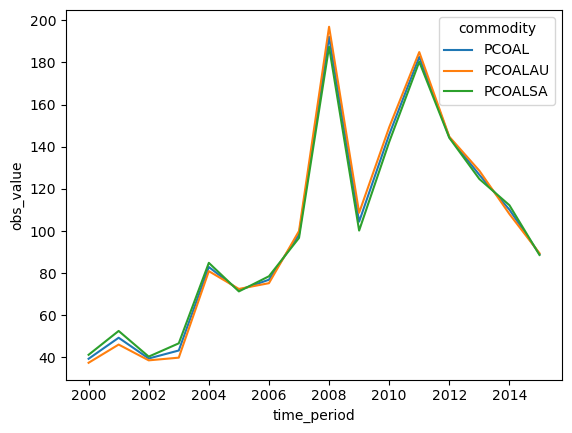

In [17]:
# Convert obs_value to numeric and time_period to integer year
df = df.astype({"time_period" : int, "obs_value" : float})

# Plot prices of different commodities in different colors with seaborn
seaborn.lineplot(data=df, x='time_period', y='obs_value', hue='commodity');


Also note that the returned data frame has mysterious-looking codes as values in some columns.

Codes in the `time_format` column are ISO 8601 duration codes. In this case, “P1Y” means “periods of 1 year.” The `unit_mult` column represents the number of zeroes you should add to the value column. For instance, if value is in millions, then the unit multiplier will be 6. If in billions, then the unit multiplier will be 9.

The meanings of the other codes are stored in our `params` object and can be fetched with a join. For instance to fetch the meaning of the `ref_area` code “W00”, we can perform a left join with the `params['ref_area']` data frame and use select to replace `ref_area` with the parameter description:

In [18]:
# Join df with params['ref_area'] to fetch code description
df = df.merge(params['ref_area'], left_on='ref_area',right_on='input_code',how='left')

# Drop redundant columns and rename description column
df = df.drop(columns=['ref_area','input_code']).rename(columns={"description":"ref_area"})

# View first few columns in the modified data frame
df.head()

,freq,commodity,unit_measure,unit_mult,time_format,time_period,obs_value,ref_area
0,A,PCOAL,IX,0,P1Y,2000,39.351023,"All Countries, excluding the IO"
1,A,PCOAL,IX,0,P1Y,2001,49.337859,"All Countries, excluding the IO"
2,A,PCOAL,IX,0,P1Y,2002,39.494909,"All Countries, excluding the IO"
3,A,PCOAL,IX,0,P1Y,2003,43.287888,"All Countries, excluding the IO"
4,A,PCOAL,IX,0,P1Y,2004,82.918586,"All Countries, excluding the IO"


## Rate and Bandwidth Limit Management

### Setting a Unique Application Name with `set_imf_app_name`

`imfp.set_imf_app_name()` allows users to set a custom application name to be used when making API calls to the IMF API. The IMF API has an application-based rate limit of 50 requests per second, with the application identified by the "user_agent" variable in the request header.

This could prove problematic if the `imfp` library became too popular and too many users tried to make simultaneous API requests using the default app name. By setting a custom application name, users can avoid hitting rate limits and being blocked by the API. `imfp.set_imf_app_name()` sets the application name by changing the `IMF_APP_NAME` variable in the environment. If this variable doesn't exist, `imfp.set_imf_app_name()` will create it.

To set a custom application name, simply call the `imfp.set_imf_app_name()` function with your desired application name as an argument:

In [ ]:
# Set custom app name as an environment variable
imfp.set_imf_app_name("my_custom_app_name")



The function will throw an error if the provided name is missing, NULL, NA, not a string, or longer than 255 characters. If the provided name is "imfr" (the default) or an empty string, the function will issue a warning recommending the use of a unique app name to avoid hitting rate limits.

### Changing the enforced wait time between API calls with `set_imf_wait_time`

By default, `imfp` enforces a mandatory 1.5-second wait time between API calls to prevent repeated or recursive calls from exceeding the API's bandwidth/rate limit. This wait time should be sufficient for most applications. However, if you are running parallel processes using `imfp` (e.g. during cross-platform testing), this wait time may be insufficient to prevent you from running up against the API's rate and bandwidth limits. You can change this wait time by calling the `set_imf_wait_time` function with a numeric value, in seconds. For instance, to enforce a five-second wait time between API calls, use `set_imf_wait_time(10)`.

Also note that by default, `imfp` functions will retry any API call rejected for bandwidth or rate limit reasons. The number of times `imfp` will attempt the call is set by the `times` argument, with a default value of 3. (With this value, requests will be retried twice after an initial failure.) Note that `imfp` enforces an exponentially increasing wait time between function calls, with a base wait time of 5 seconds on the first retry, so it is not recommended to set a high value for `times`.

## Planned features

- If pyproject.toml version has been incremented, automatically deploy Github release from main with release notes auto-generated from `News` file or PR message
- Implement automatic build/render of readthedocs documentation with Sphinx
- Implement automatic build/release/publish of package updates
- Move response mocking functionality from `_download_parse` to `_imf_get`
- Investigate and implement different and more appropriate exception types, as we're currently handling too many different cases with `ValueError`
- More fully investigate the types of metadata available through the API and the most appropriate way to return them when a user calls `include_metadata`
- Implement optional response caching for `imf_databases` and `imf_parameters`
- Simplify and modularize some of the code, particularly in `imf_dataset`

## Contributing

I would love to have your help in improving `imfp`. If you encounter a bug while using the library, please open an issue. Alternatively, fix the bug and open a pull request to the `dev` branch. Thanks in advance for your help!

Note to maintainers: To deploy a new version of the package, increment the version number with `poetry version patch` (or `minor`/`major` for larger updates), update the lock file with the latest dependencies with `poetry update`, run the tests with `pytest tests`, make any necessary documentation changes in `NEWS` and `README.ipynb`, and push to dev. Github Actions will automatically format the code with black, render the README, and run the unit tests. If the workflow completes successfully, open a PR to main. After merging, the workflow will test again as one last sanity check and then automatically deploy the new version to PyPi. Currently, new Github releases must be created manually, but this will be automated in the future.